In this notebook you'll find a range of tests showcasing how leakage is detected using our repostory. Different types of scrambling methods with different parameteres have been tested. The result is either visualized or reported at the bottom of the related test. 

## Data
This test is using a 4D fMRI image, that each time you run a test will be downloaded and deleted at the end. Read more about data in this [link](https://openneuro.org/datasets/ds004934/versions/1.0.0) which OpenNeuro is hosting.

Each cell in this notebook is associated with different scrambling method and its parameters.


## Methods:
We have tested the leakage score using three known methods. 
- [[Pearson correlation]](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://en.wikipedia.org/wiki/Pearson_correlation_coefficient&ved=2ahUKEwic1fmek9KNAxVp2QIHHef7MlIQFnoECDMQAQ&usg=AOvVaw0oS2sNVkApYvcS_BsC8s3p): A mathematical correlation coefficient representing the relationship between one 2D slice of original vs. corresponding scrambled 2D slice.
- Structural Similarity Index Measure[[SSIM]](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://en.wikipedia.org/wiki/Structural_similarity_index_measure&ved=2ahUKEwjWrMKvktKNAxUR1QIHHcsFMcsQFnoECBAQAQ&usg=AOvVaw0DeKf5zozxPyKboaovBeRN): A perceptual metric that quantifies image quality degradation caused by scrambling.
- Identical[[np.allclose]](https://numpy.org/doc/2.1/reference/generated/numpy.allclose.html): Searches for exact identical arrays of voxels
## What to expect:
- We increase the intensity of different scrambling methods and run our leakage detection method, thus we expect to see less leakage as intensity increases. 
- At the bottom of each test, we visualize either plots to track leakage or a report inlcuding basic descriptive statistics with distribution plots. 
- The x-axis in the plots shows scrambling parameter, and y-axis shows leakage score.
  
## List of tests:
- Original Vs. Original
- Permutation
- Permutation - slices replaced
- Wobble
- Scatter
- Blur


In [2]:
import os, sys, subprocess, csv, random, wget, shutil
import numpy as np
from IPython.display import HTML, display
import matplotlib.pyplot as plt

In [20]:
def viz(f, crit): 
    pl = [float(x[0]) for x in f]
    fl = [int(x[1]) for x in f]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    ax1.plot(list(crit),pl, color='skyblue')
    ax1.set_title("Partial Leakage")
    ax1.set_xlabel("Scrambling parameter")
    ax1.set_ylabel("Leakage score")
    ax2.plot(list(crit),fl, color='skyblue')
    ax2.set_title("Full Leakage")
    ax2.set_xlabel("Scrambling parameter")
    
    plt.tight_layout()
    plt.show()

def run_test(files=list, opt=list, scramble=True, clean=True, disp=False):
    
    os.makedirs("img", exist_ok=True)
    link_original = "https://s3.amazonaws.com/openneuro.org/ds004934/sub-SAXNES2s001/func/sub-SAXNES2s001_task-DOTS_run-001_bold.nii.gz?versionId=R0fwRS9fxw8CcPZnb4zYsw9I5v19aAbP"
    wget.download(link_original)
    os.makedirs("input/func/original", exist_ok=True)
    file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file.endswith(".gz")]
    shutil.copy2(file_[0], "input/func/original")
    os.remove(file_[0])
    print(f"\nOriginal file downloaded.")
    script = os.path.join(os.path.dirname(os.getcwd()), "run_test.py")
    original = files[0]
    scrambled = files[1]
    params = {
        "input": original,
        "output": scrambled,
        "opts": opts
    }
    if scramble:
        ! scramble "{params['input']}" "{params['output']}" {" ".join(params['opts'])}
    print(f"Original file is scrambled.")
    result= subprocess.run(
        ["python3", script, original, scrambled, "True"],
        capture_output=True,
        text=True
    )
    print(f"Analysis is finished.")
    print(result.stdout)
    
    if disp:
        file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()+"/report/") for file in files if file.endswith(".html")]
        with open(file_[0]) as f:
            display(HTML(f.read()))
    print(f"Cleaning up ...")    
    if clean:
        ! rm -r input report img


# Original Vs. Original
We test the same original image and we expect to see full leakage.

For more details, we can check the visualization where you can see the distribution of identicals.
## What to expect:
We expect to see identified full leakage since both images are similar

100% [....................................................] 60545196 / 60545196
Original file downloaded.
Original file is scrambled.
Analysis is finished.
########################################
 - Subject ID: sub-SAXNES2s001
 - Task: DOTS
 - Run: run-001
 - Shape: (70, 70, 50, 248)
########################################
 - Full-volume Spatiotemporal Analysis
	 - Dimension[X]: 	Full Leakage: 69/70 slices	Partial Leakage: 1.0
	 - Dimension[Y]: 	Full Leakage: 70/70 slices	Partial Leakage: 1.0
	 - Dimension[Z]: 	Full Leakage: 50/50 slices	Partial Leakage: 1.0
	 - Dimension[T]: 	Full Leakage: 248/248 slices	Partial Leakage: 1.0
 - Localized Spatiotemporal cube-wise Analysis
	 - Total cubes: 245000 	Shape (1, 1, 1, 248)
	 - SpatioTemporal: 	Full Leakage: 241095/245000 cubes 	Partial Leakage 1.0
 - Partial Leakage: 1.0
 - Full Leakage: True
 - Please consider applying scramble on your dataset again.

Total time taken: 00:01:05




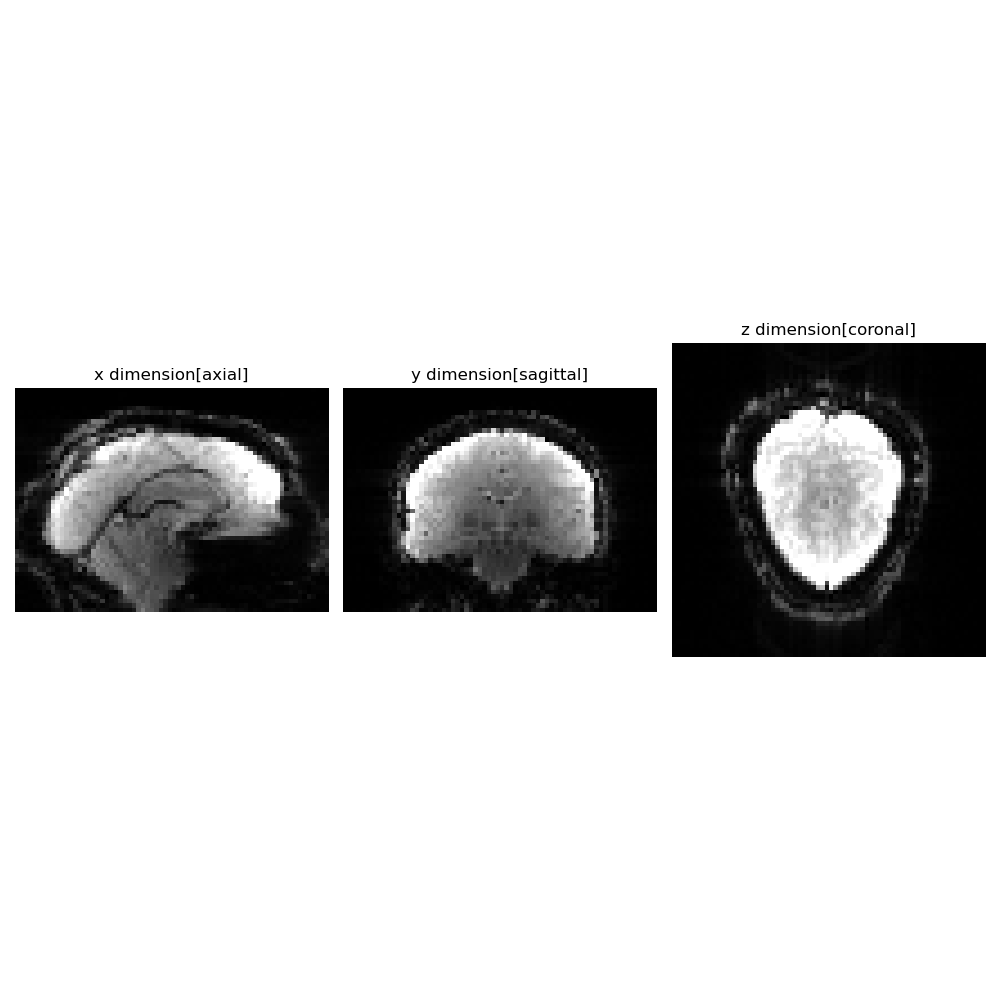
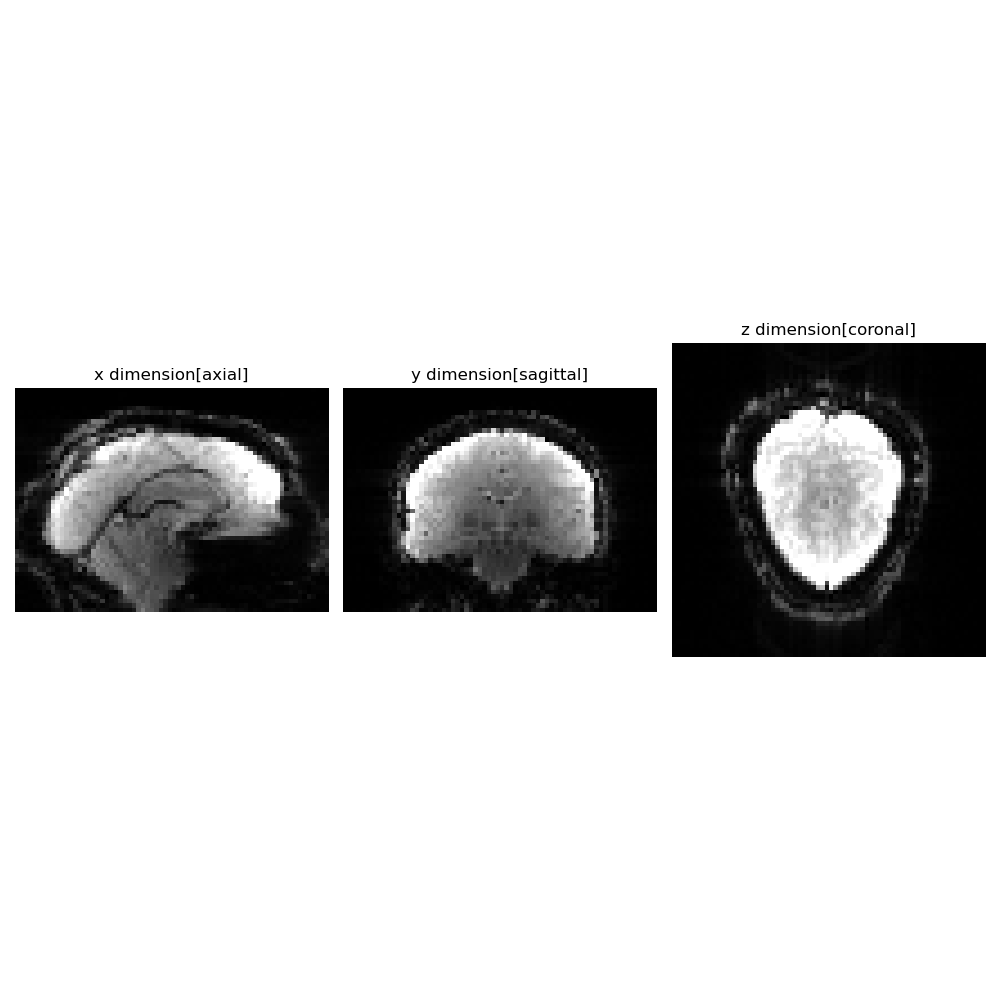
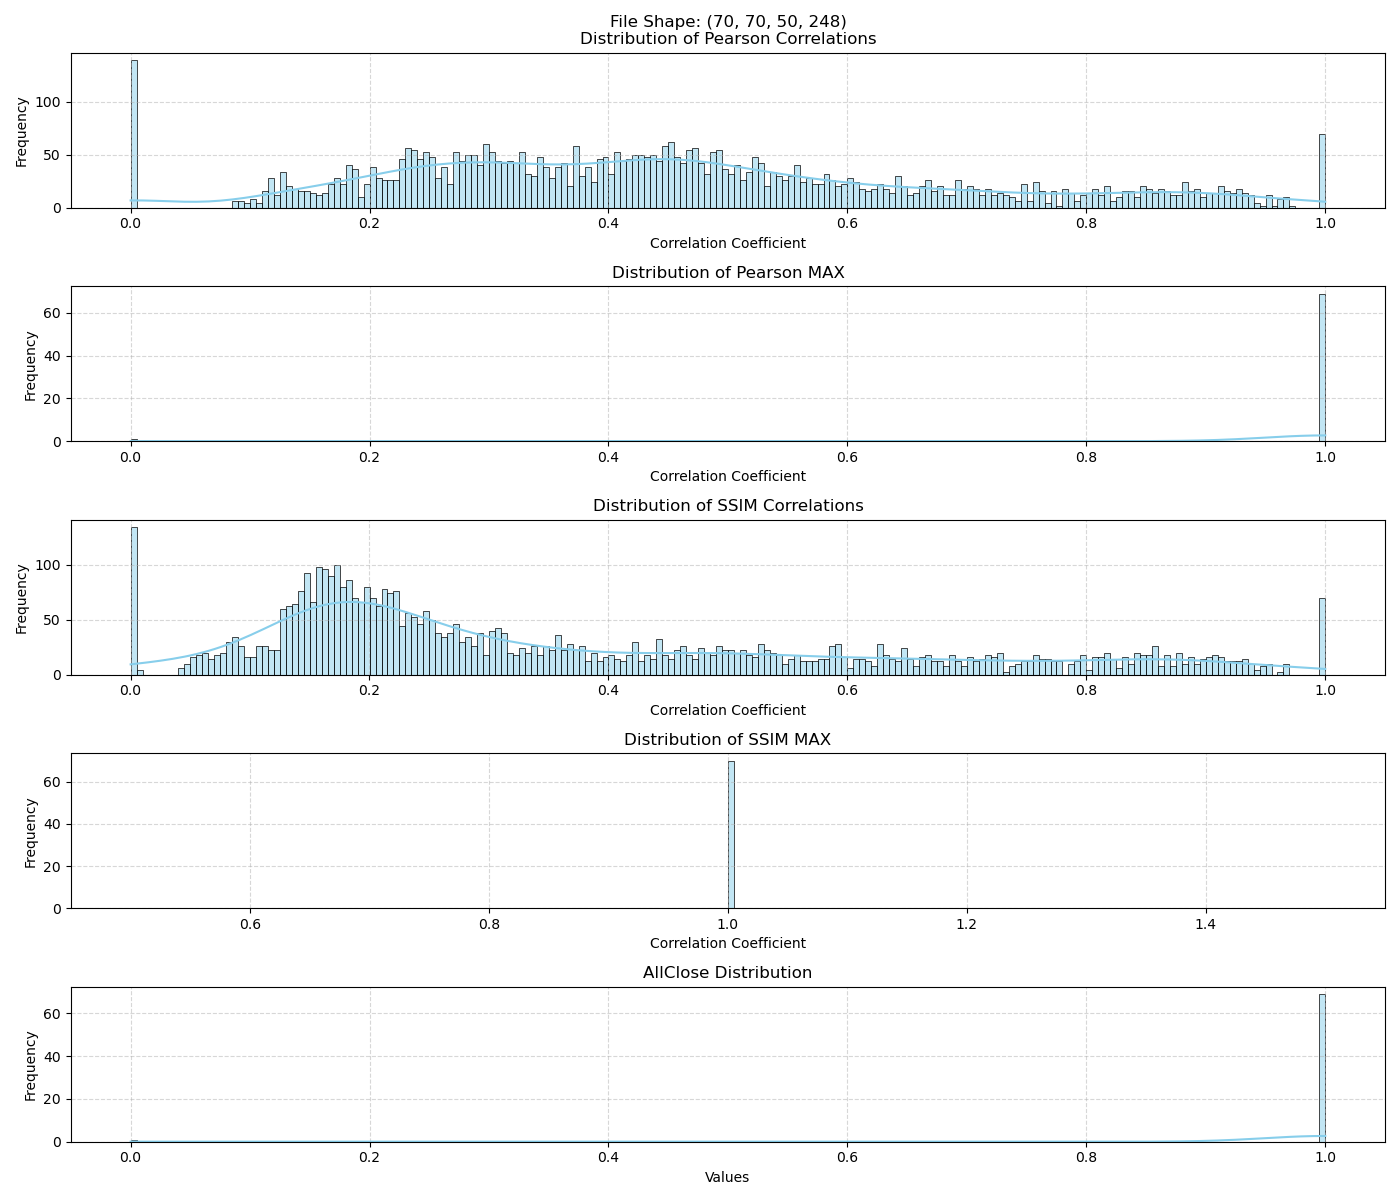
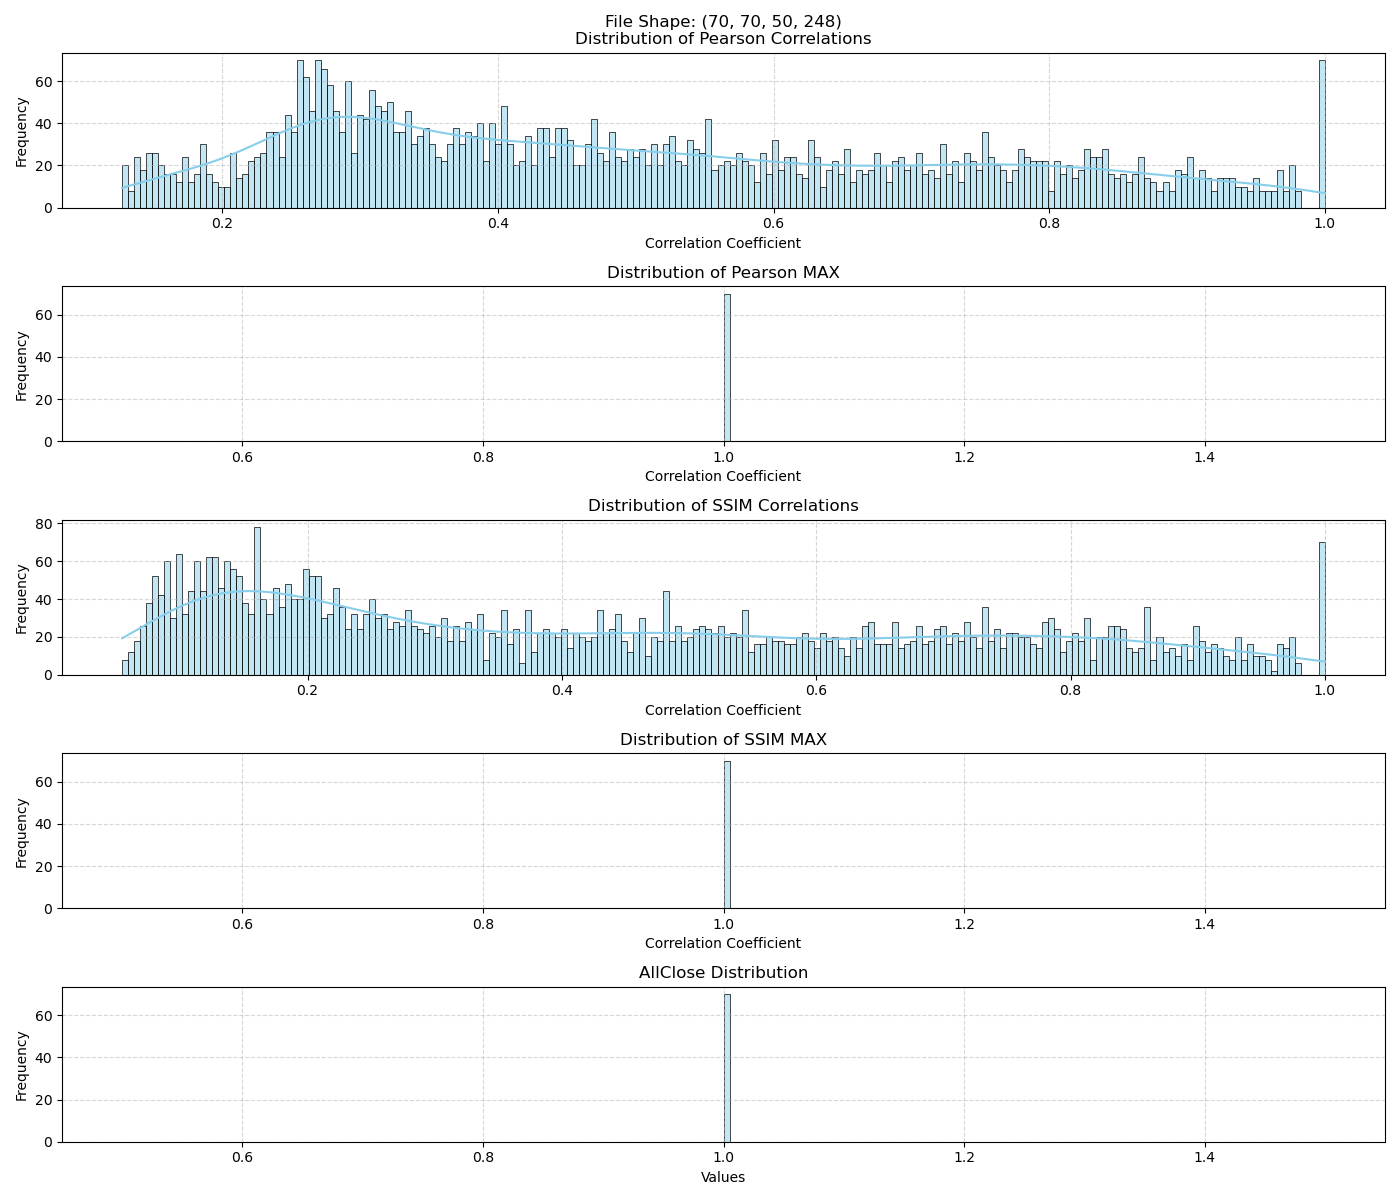
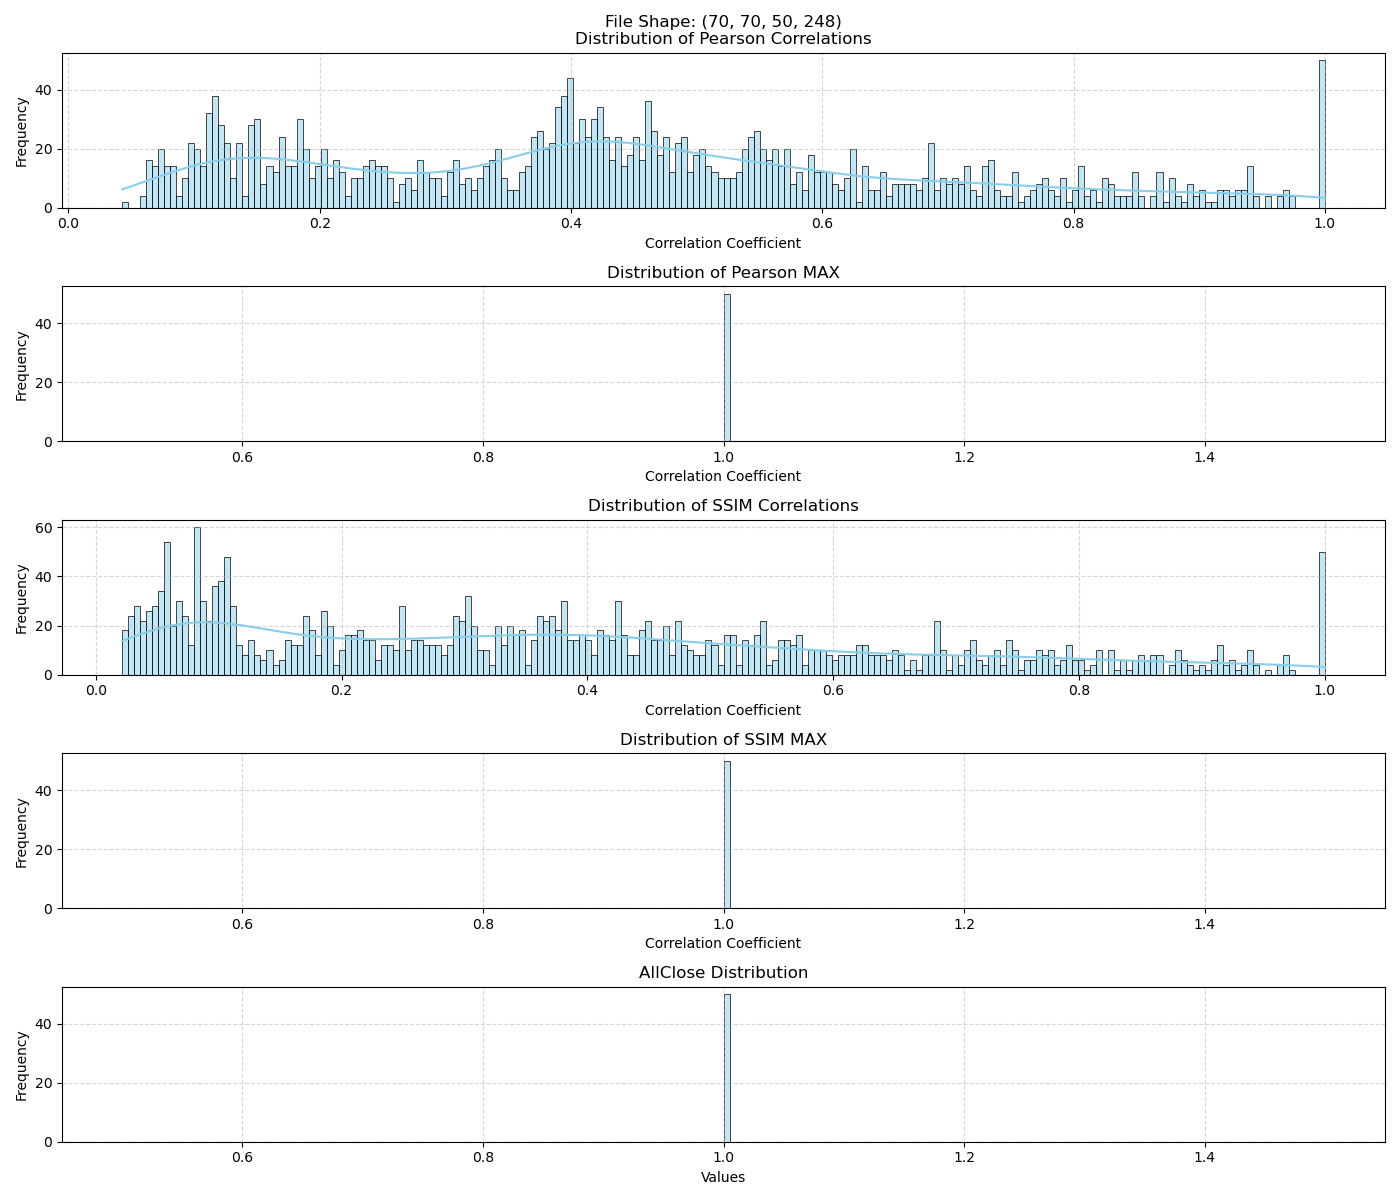

Cleaning up ...


In [21]:
original = "input/func/original/"
scrambled = "input/func/scrambled/"
files = [original, original]
run_test(files, scramble=False, clean=False, disp=True) # NOTE: If original vs. original, then clean=False, otherwise original file gets deleted.

# Method: Permutation
In this case we **permute** the image to see how scramble affect the leakage.
Permutation is done in two different ways.

- Independently where we pass **-i** as argument, which all arrays in the given axis are permuted independently.
- Without **-i** the given axis remain as it is, while other axis are permuted.
  
We test permutation on each axis w/o passing **-i** as argument

100% [....................................................] 60545196 / 60545196Found 1 input files and 0 directories using '(?!\.).*'
Saving: /indirect/staff/vincentajoubi/Don't look/DL/test/input/func/scrambled/sub-SAXNES2s001_task-DOTS_run-001_bold.nii.gz
100% [....................................................] 60545196 / 60545196 37s/file]
Original file downloaded.
Original file is scrambled.
Analysis is finished.
########################################
 - Subject ID: sub-SAXNES2s001
 - Task: DOTS
 - Run: run-001
 - Shape: (70, 70, 50, 248)
########################################
 - Full-volume Spatiotemporal Analysis
	 - Dimension[X]: 	Full Leakage: 0/70 slices	Partial Leakage: 0.49
	 - Dimension[Y]: 	Full Leakage: 0/70 slices	Partial Leakage: 0.3
	 - Dimension[Z]: 	Full Leakage: 0/50 slices	Partial Leakage: 0.37
	 - Dimension[T]: 	Full Leakage: 0/248 slices	Partial Leakage: 0.32
 - Localized Spatiotemporal cube-wise Analysis
	 - Total cubes: 245000 	Shape (1, 1, 1, 248)
	 - S

ValueError: x and y must have same first dimension, but have shapes (8,) and (9,)

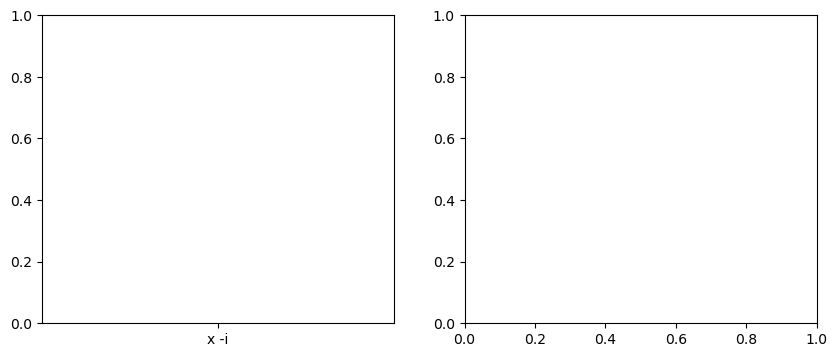

In [22]:
original = "input/func/original/"
scrambled = "input/func/scrambled/"
files = [original, scrambled]
opts = ["nii", "permute", 
        [["x -i"], ["y -i"], ["z -i"], ["t -i"], ["x"], ["y"], ["z"], ["t"]]] 

for i in opts[2]:
    link_original = "https://s3.amazonaws.com/openneuro.org/ds004934/sub-SAXNES2s001/func/sub-SAXNES2s001_task-DOTS_run-001_bold.nii.gz?versionId=R0fwRS9fxw8CcPZnb4zYsw9I5v19aAbP"
    wget.download(link_original)
    os.makedirs("input/func/original", exist_ok=True)
    file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file.endswith(".gz")]
    shutil.copy2(file_[0], "input/func/original")
    os.remove(file_[0])
    opt_ = " ".join([opts[0], opts[1], i[0]]).split(" ")
    ! scramble "{files[0]}" "{files[1]}" {" ".join(opt_)}
    run_test(files, opt=opt_, clean=True, scramble=False)

with open("result.tsv", "r") as file:
    f = csv.reader(file, delimiter="\t")
    f = [row for row in f]
        
viz(f,[i[0] for i in opts[2]])
! rm result.tsv

# Permute -independently with slices inserted from original to scrambled image

Here we randomly replace slices of original image to the exact position of the permuted version. Permutation is done independently, so the image is totally unrecognizable, regardless of which axis.


## What to expect:
By default an independent permutation of the image should suffice privacy, but since we are inserting **n** images of original to the scrambled version, we expect to see **n** identical images, resulting to full leakage. NOTE: Image slices are randomly chosen to be replaced. Therefore there's possibility of choosing same slice multiple times.

100% [....................................................] 60545196 / 60545196Found 1 input files and 0 directories using '(?!\.).*'
Saving: /indirect/staff/vincentajoubi/Don't look/DL/test/input/func/scrambled/sub-SAXNES2s001_task-DOTS_run-001_bold.nii.gz
100% [....................................................] 60545196 / 60545196 47s/file]
Original file downloaded.
Original file is scrambled.
Analysis is finished.
########################################
 - Subject ID: sub-SAXNES2s001
 - Task: DOTS
 - Run: run-001
 - Shape: (70, 70, 50, 248)
########################################
 - Full-volume Spatiotemporal Analysis
	 - Replaced indices in x: [46, 39, 18, 38, 27]
	 - Dimension[X]: 	Full Leakage: 5/70 slices	Partial Leakage: 1.0
	 - Replaced indices in y: [60, 43, 34, 60, 39]
	 - Dimension[Y]: 	Full Leakage: 4/70 slices	Partial Leakage: 1.0
	 - Replaced indices in z: [38, 40, 37, 36, 33]
	 - Dimension[Z]: 	Full Leakage: 5/50 slices	Partial Leakage: 1.0
	 - Replaced indices in 

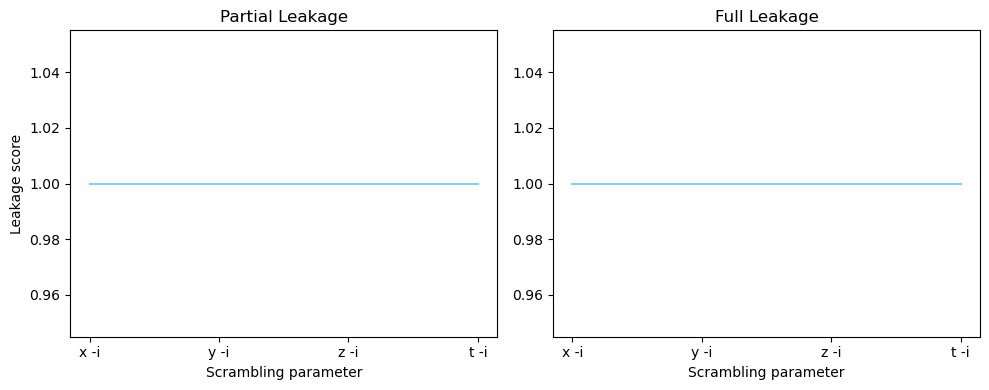

In [32]:
original = "input/func/original/"
scrambled = "input/func/scrambled/"
files = [original, scrambled]
opts = ["nii", "permute", 
        [["x -i"], ["y -i"], ["z -i"], ["t -i"]]] 

for i in opts[2]:
    link_original = "https://s3.amazonaws.com/openneuro.org/ds004934/sub-SAXNES2s001/func/sub-SAXNES2s001_task-DOTS_run-001_bold.nii.gz?versionId=R0fwRS9fxw8CcPZnb4zYsw9I5v19aAbP"
    wget.download(link_original)
    os.makedirs("input/func/original", exist_ok=True)
    file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file.endswith(".gz")]
    shutil.copy2(file_[0], "input/func/original")
    os.remove(file_[0])
    opt_ = " ".join([opts[0], opts[1], i[0]]).split(" ")
    ! scramble "{files[0]}" "{files[1]}" {" ".join(opt_)}
    run_test(files, opt=opt_, clean=True, scramble=False)

with open("result.tsv", "r") as file:
    f = csv.reader(file, delimiter="\t")
    f = [row for row in f]
        
viz(f,[i[0] for i in opts[2]])
! rm result.tsv

This is the same exact test as prevoius one, along permutaion independently only on x-axis with report.

## what to expect:
In the report you can see the distribution plots of this test for more details, alongside minimum, maximum and average leakage along each axis. We expect to see in the plots **n** number of images which is identical to the original image, since slices are replaced from original.

100% [....................................................] 60545196 / 60545196
Original file downloaded.
Found 1 input files and 0 directories using '(?!\.).*'
Saving: /indirect/staff/vincentajoubi/Don't look/DL/test/input/func/scrambled/sub-SAXNES2s001_task-DOTS_run-001_bold.nii.gz
Original file is scrambled.                                                     57s/file]
Analysis is finished.
########################################
 - Subject ID: sub-SAXNES2s001
 - Task: DOTS
 - Run: run-001
 - Shape: (70, 70, 50, 248)
########################################
 - Full-volume Spatiotemporal Analysis
	 - Replaced indices in x: [57, 49, 42, 59, 40]
	 - Dimension[X]: 	Full Leakage: 5/70 slices	Partial Leakage: 1.0
	 - Replaced indices in y: [18, 48, 41, 38, 23]
	 - Dimension[Y]: 	Full Leakage: 5/70 slices	Partial Leakage: 1.0
	 - Replaced indices in z: [33, 36, 17, 33, 29]
	 - Dimension[Z]: 	Full Leakage: 4/50 slices	Partial Leakage: 1.0
	 - Replaced indices in t: [29, 25, 150, 96, 217]
	


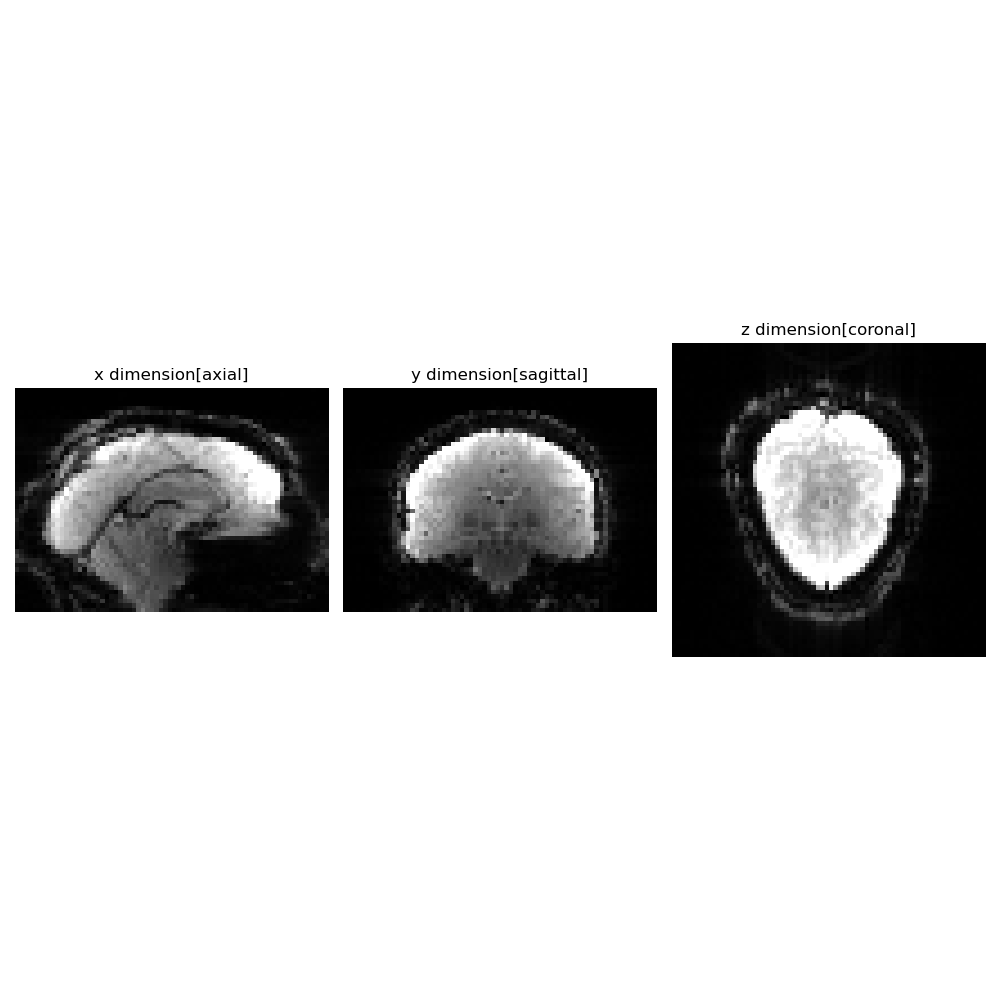
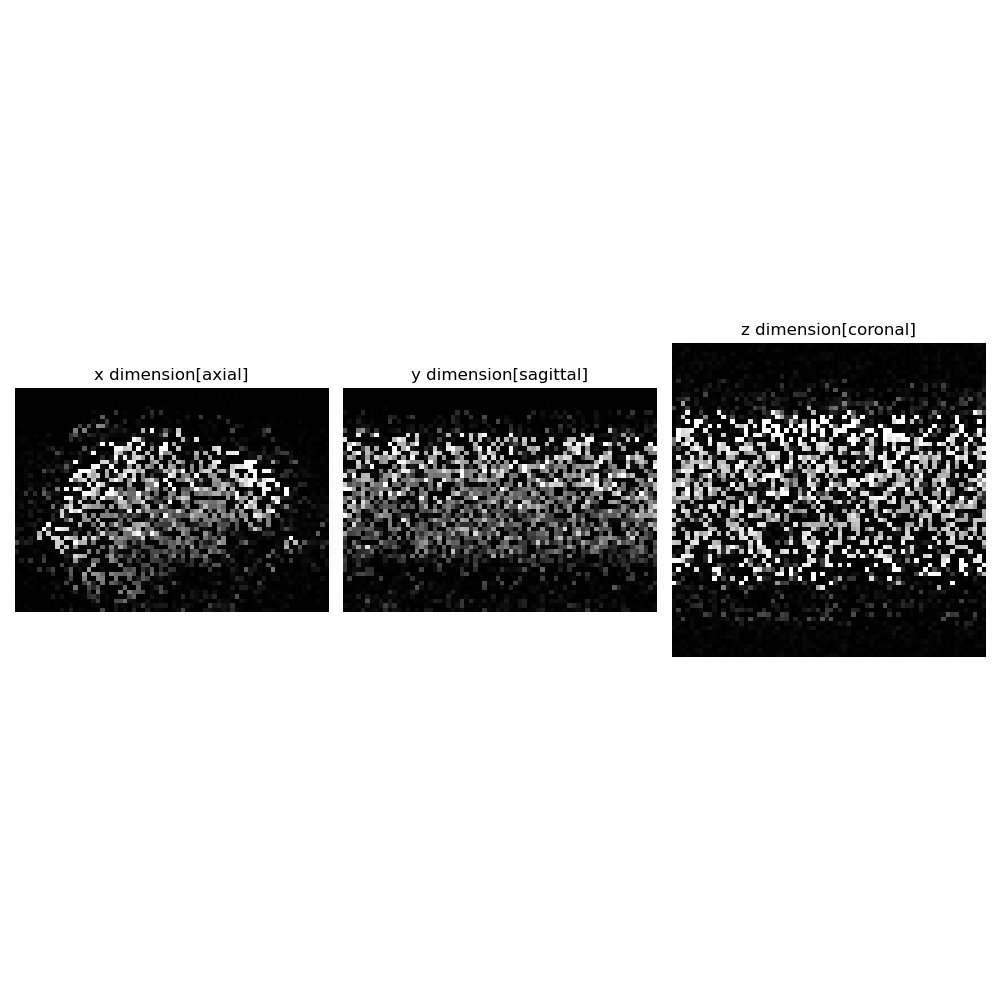
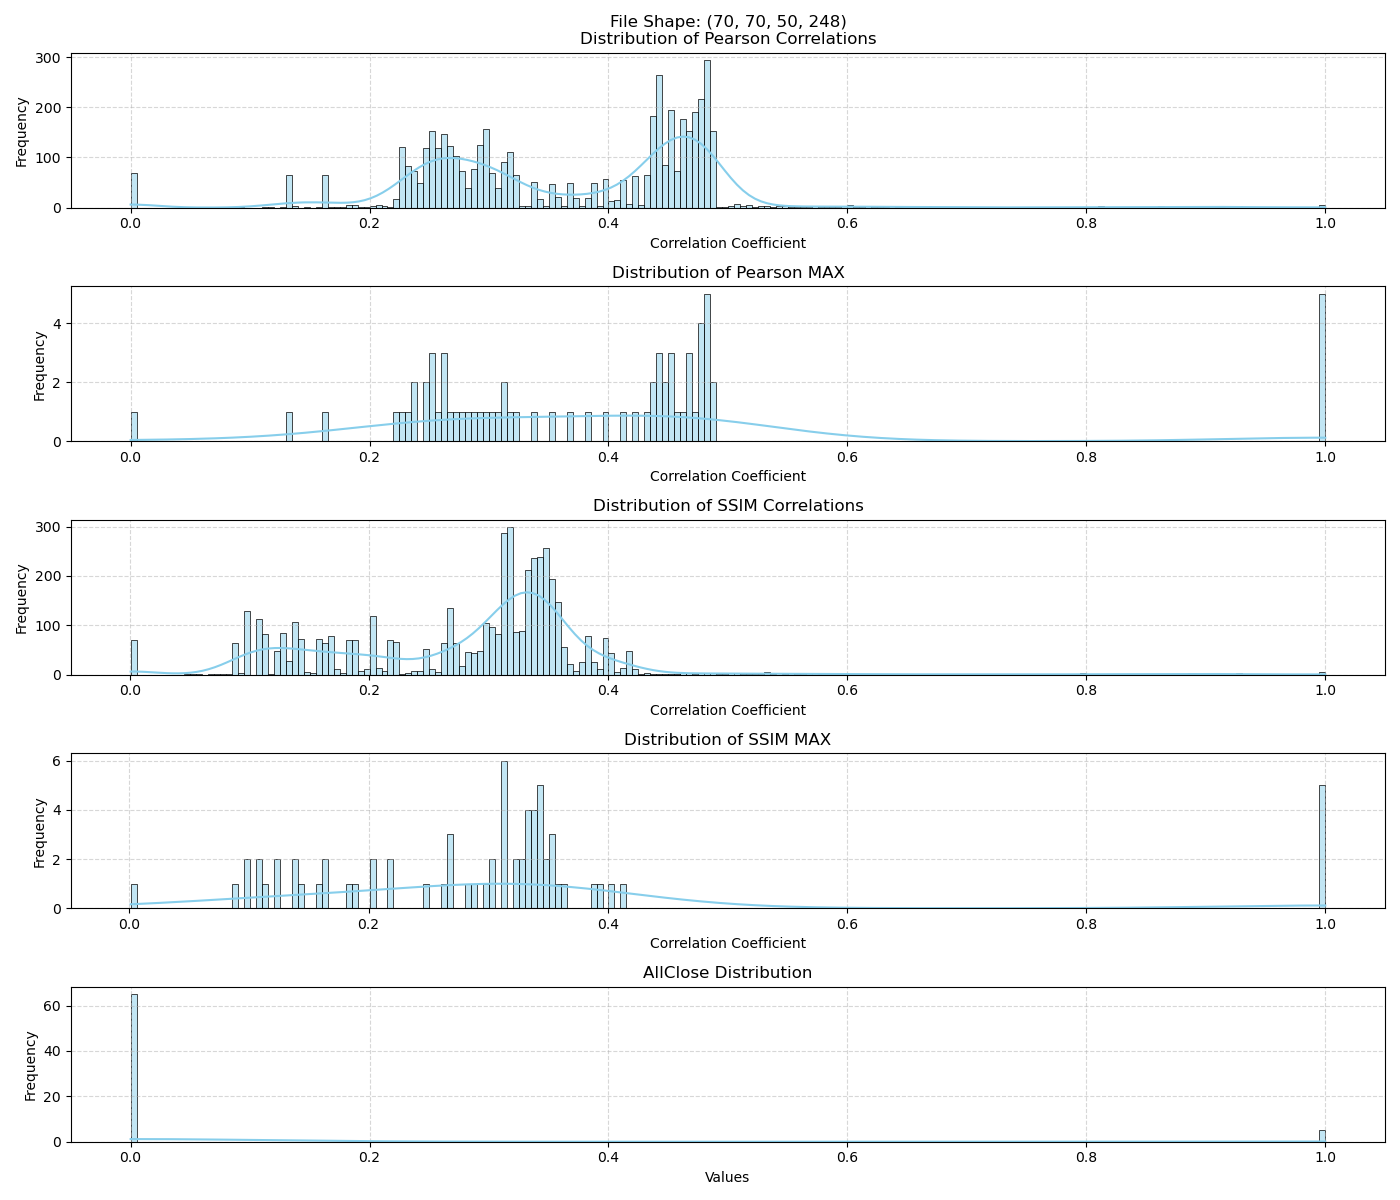
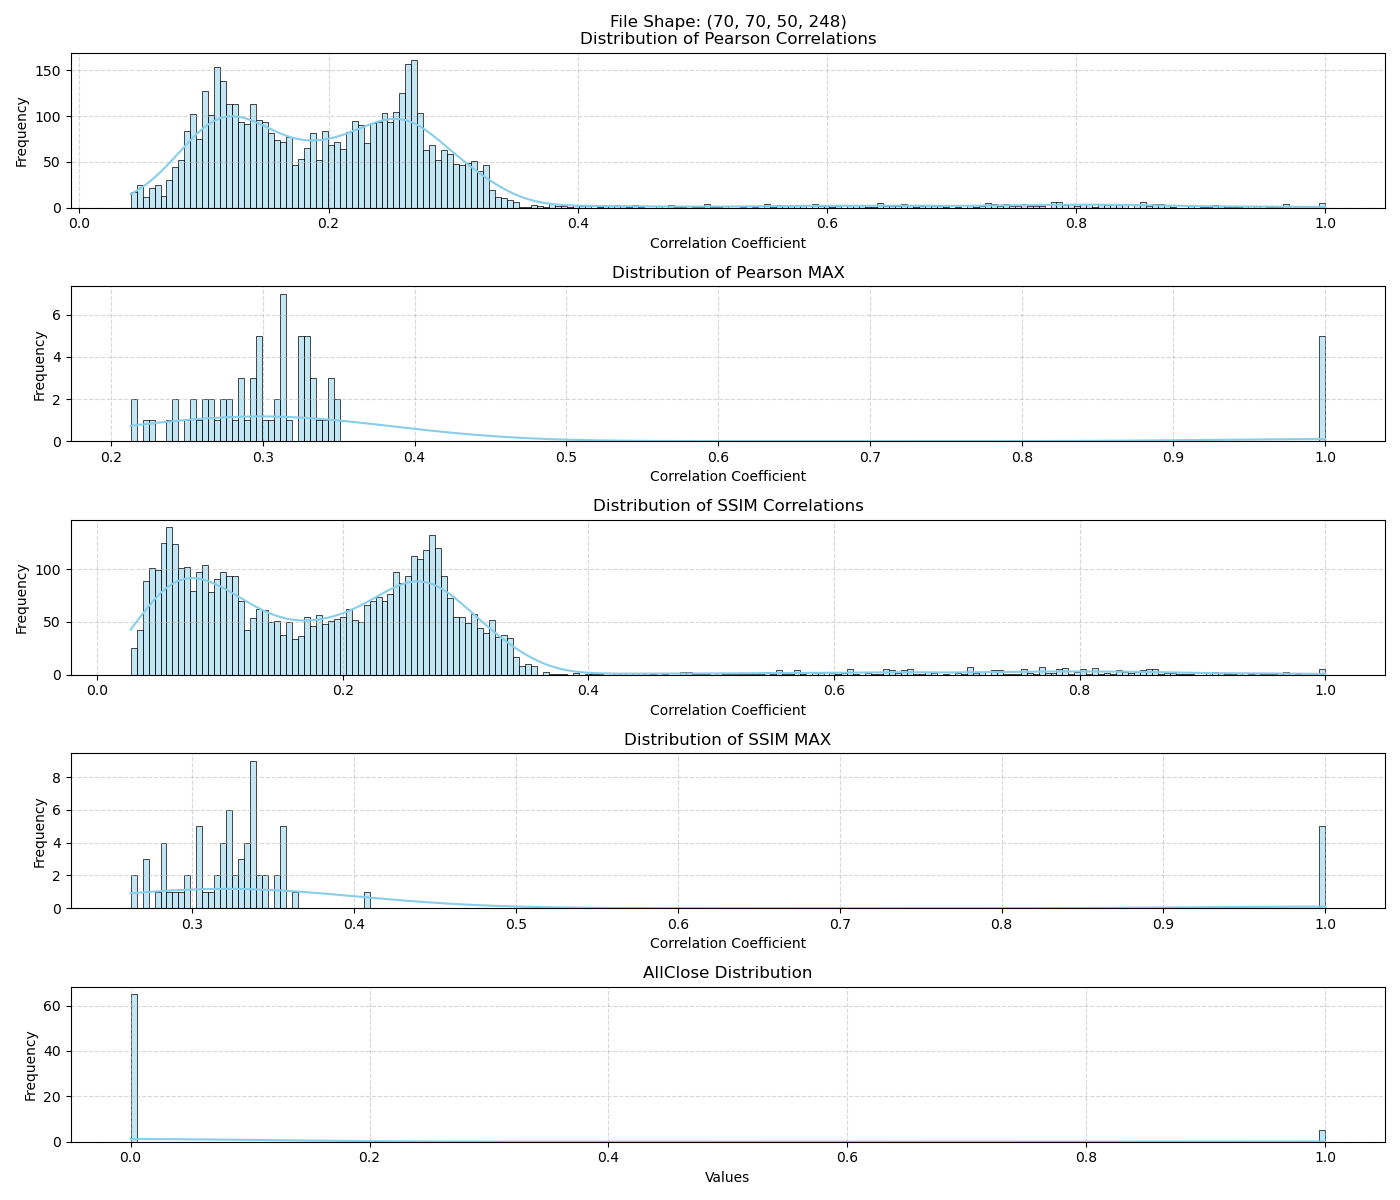
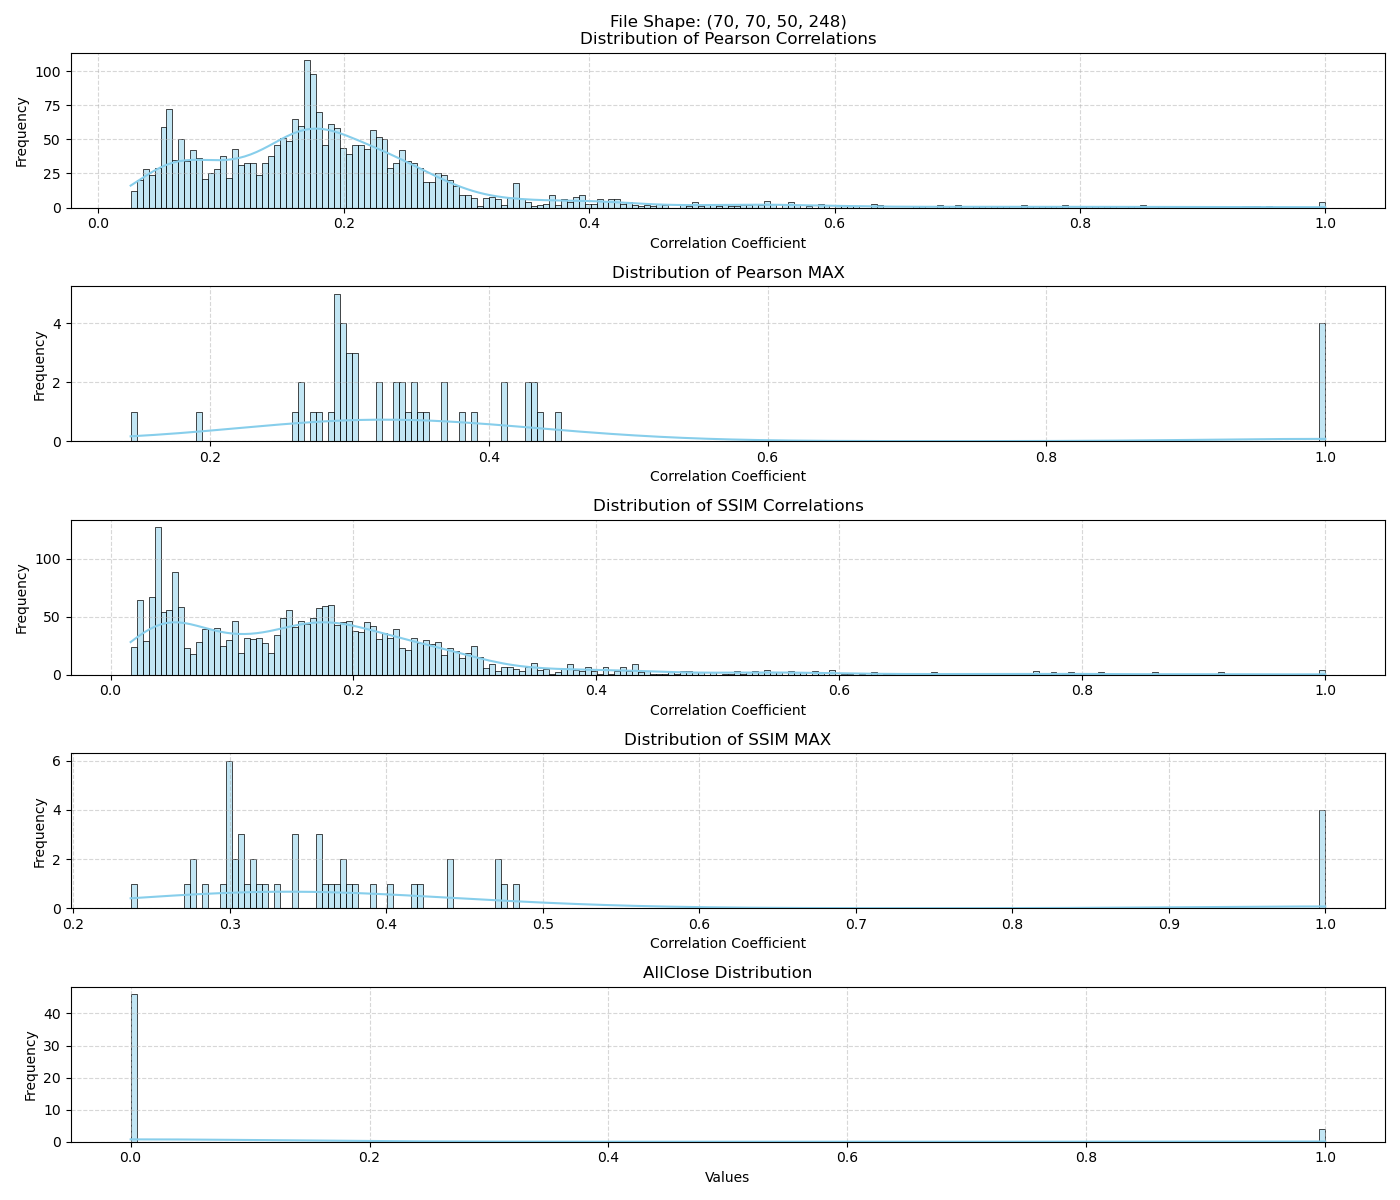

Cleaning up ...


In [33]:
original = "input/func/original/"
scrambled = "input/func/scrambled/"
files = [original, scrambled]
opts = ["nii", "permute", "x -i"] 

run_test(files, opt=opts, clean=True, disp=True)

# Wobble
We demonstrate a test case in if scrambling is "Wobble" with different parameters. 
## What to expect:
We expect lesser leakage as the intensity of wobbling is higher.

At the bottom, we visualize the result of **full** and **partial leakage** where x-axis shows the wobbling intensity and y-axis is leakage 

100% [....................................................] 60545196 / 60545196
Original file downloaded.
Found 1 input files and 0 directories using '(?!\.).*'
Saving: /indirect/staff/vincentajoubi/Don't look/DL/test/input/func/scrambled/sub-SAXNES2s001_task-DOTS_run-001_bold.nii.gz
Original file is scrambled.                                                     92s/file]
Analysis is finished.
########################################
 - Subject ID: sub-SAXNES2s001
 - Task: DOTS
 - Run: run-001
 - Shape: (70, 70, 50, 248)
########################################
 - Full-volume Spatiotemporal Analysis
	 - Dimension[X]: 	Full Leakage: 0/70 slices	Partial Leakage: 0.37
	 - Dimension[Y]: 	Full Leakage: 0/70 slices	Partial Leakage: 0.4
	 - Dimension[Z]: 	Full Leakage: 0/50 slices	Partial Leakage: 0.37
	 - Dimension[T]: 	Full Leakage: 0/248 slices	Partial Leakage: 0.32
 - Localized Spatiotemporal cube-wise Analysis
	 - Total cubes: 245000 	Shape (1, 1, 1, 248)
	 - SpatioTemporal: 	Full Leakag

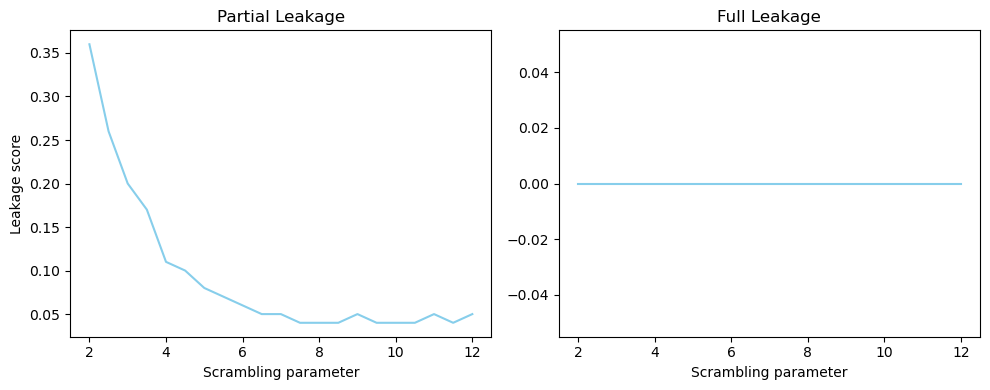

In [29]:
opts = ["nii", "wobble", "-a ", "_"]
original = "input/func/original/"
scrambled = "input/func/scrambled/"
files = [original, scrambled] 
crit = np.arange(2.0, 12.5, 0.5, dtype=float)

for p in crit:
    opts[3] = str(p)
    run_test(files, opt=opts, clean= False)

with open("result.tsv", "r") as file:
    f = csv.reader(file, delimiter="\t")
    f = [row for row in f]
        
viz(f,crit)
! rm result.tsv

# Method: Scatter

100% [....................................................] 60545196 / 60545196
Original file downloaded.
Found 1 input files and 0 directories using '(?!\.).*'
window: [2 2 1]                                                                  ?file/s]
step: [1, 1, 1]
Saving: /indirect/staff/vincentajoubi/Don't look/DL/test/input/func/scrambled/sub-SAXNES2s001_task-DOTS_run-001_bold.nii.gz
Original file is scrambled.                                                     85s/file]
Analysis is finished.
########################################
 - Subject ID: sub-SAXNES2s001
 - Task: DOTS
 - Run: run-001
 - Shape: (70, 70, 50, 248)
########################################
 - Full-volume Spatiotemporal Analysis
	 - Dimension[X]: 	Full Leakage: 0/70 slices	Partial Leakage: 0.89
	 - Dimension[Y]: 	Full Leakage: 0/70 slices	Partial Leakage: 0.91
	 - Dimension[Z]: 	Full Leakage: 0/50 slices	Partial Leakage: 0.99
	 - Dimension[T]: 	Full Leakage: 0/248 slices	Partial Leakage: 0.88
 - Localized Spati

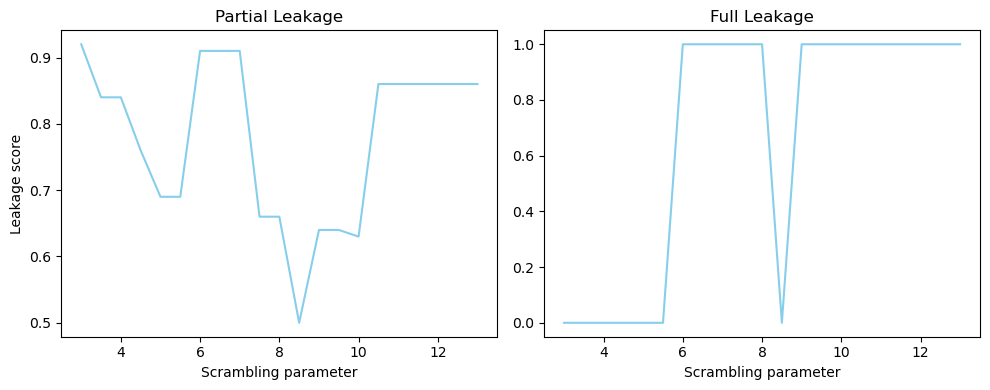

In [34]:
opts = ["nii", "scatter", "_"]
original = "input/func/original/"
scrambled = "input/func/scrambled/"
files = [original, scrambled]
crit = np.arange(3, 13.5, 0.5, dtype=float)

for p in crit:
    opts[2] = str(p)
    run_test(files, opt=opts, clean= True)

with open("result.tsv", "r") as file:
    f = csv.reader(file, delimiter="\t")
    f = [row for row in f]
        
viz(f,crit)
! rm result.tsv

# Blur
Apply a 3D Gaussian smoothing filter. This method removes details and noise to blur the image.

## What to expect:
We expect to see less partial leakage as the intensity of the blurring increases, and perhaps full leakage when blurring is at the lowest level.

100% [....................................................] 60545196 / 60545196
Original file downloaded.
Found 1 input files and 0 directories using '(?!\.).*'
Saving: /indirect/staff/vincentajoubi/Don't look/DL/test/input/func/scrambled/sub-SAXNES2s001_task-DOTS_run-001_bold.nii.gz
Original file is scrambled.                                                     87s/file]
Analysis is finished.
########################################
 - Subject ID: sub-SAXNES2s001
 - Task: DOTS
 - Run: run-001
 - Shape: (70, 70, 50, 248)
########################################
 - Full-volume Spatiotemporal Analysis
	 - Dimension[X]: 	Full Leakage: 57/70 slices	Partial Leakage: 1.0
	 - Dimension[Y]: 	Full Leakage: 70/70 slices	Partial Leakage: 1.0
	 - Dimension[Z]: 	Full Leakage: 46/50 slices	Partial Leakage: 1.0
	 - Dimension[T]: 	Full Leakage: 248/248 slices	Partial Leakage: 1.0
 - Localized Spatiotemporal cube-wise Analysis
	 - Total cubes: 245000 	Shape (1, 1, 1, 248)
	 - SpatioTemporal: 	Full Leak

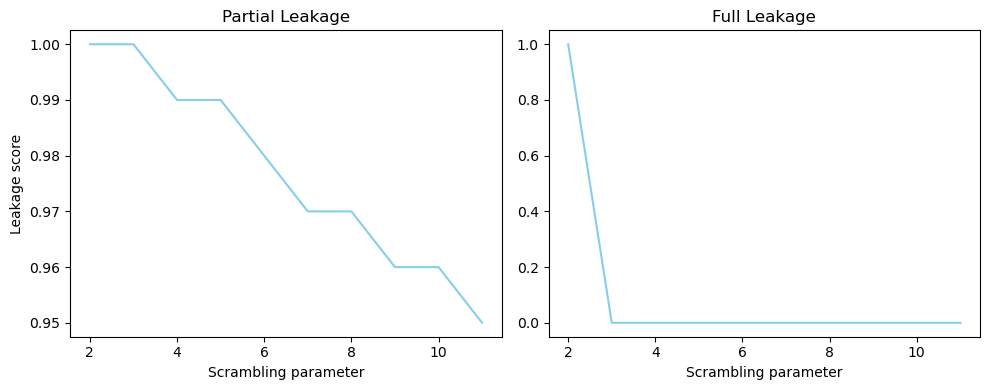

In [35]:
opts = ["nii", "blur", "_"]
original = "input/func/original/"
scrambled = "input/func/scrambled/"
files = [original, scrambled] 
crit = np.arange(2.0, 12.0, 1.0, dtype=float)

for p in crit:
    opts[2] = str(p)
    run_test(files, opt=opts, clean= False)

with open("result.tsv", "r") as file:
    f = csv.reader(file, delimiter="\t")
    f = [row for row in f]
        
viz(f,crit)
! rm result.tsv